<a href="https://colab.research.google.com/github/rinrin528/AIFFEL-1st-Hackathon/blob/main/EDA/EDA%ED%86%B5%ED%95%A9%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# 구글드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 데이터 분석 및 모델 학습 라이브러리
import numpy as np
import pandas as pd
from sklearn import ensemble, neighbors, linear_model, metrics, preprocessing
from datetime import datetime
import glob, re
import time, datetime
from datetime import timedelta

# 시각화 라이브러리
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# 해커톤1. 레스토랑 방문자 수 예측하기

## 데이터셋: [Recruit Restaurant Visitor Forecasting | Kaggle](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/overview)



---



## 🔍문제 이해하기
-	a time-series forecasting problem
-	2개 사이트에서 얻은 데이터셋이다.
 - hpg (Hot Pepper Gourmet): 레스토랑을 찾거나 예약할 수 있는 사이트
 - air (AirReGI/Restaurant Borad): 예약 관리, 사전계산 가능한 사이트
-	훈련데이터는 **2016년부터 2017년4월**까지, 테스트데이터는 **2016년 4월마지막주부터 5월**동안의 데이터이다. <br> (테스트데이터는 의도적으로 휴가철 데이터를 설정하였다.)
-	테스트셋에서 레스토랑이 닫거나 방문자가 없는 날은 scoring되지 않는다. 훈련데이터셋에서는 레스토랑이 닫은 날은 생략했다.



---




## 📊데이터셋 이해하기 (8개)

**1.	air_reserve:** air사이트에서 이뤄진 예약들<br>
- 칼럼) air_store_id, visit_datetime(방문시각), reserve_datetime(예약시각), reserve_visitors(예약방문자수)

**2.	hpg_reserve:** hpg사이트에서 이뤄진 예약들<br>
- 칼럼) hpg_store_id, visit_datetime, reserve_datetime, reserve_visitors<br>

**3.	air_store_info:** air사이트의 레스토랑 정보<br>
- 칼럼) air_store_id, air_genre_name(레스토랑종류), air_area_name(지역구이름), latitude(위도), longitude(경도)<br>

**4.	hpg_store_info:** hpg사이트의 레스토랑 정보<br>
- 칼럼) hpg_store_id, hpg_genre_name, hpg_area_name, latitude, longitude<br>

**5.	store_id_relation**<br>
- 칼럼) hpg_store_id, air_store_id<br>

**6.	air_visit_data**: air레스토랑들의 방문이력을 보여준다.
- **training 데이터**
- 칼럼) air_store_id, visit_date, <u>visitors(방문자수)</u><br>

**7.	sample_submission:** 우리가 예측해야하는 정답과 정답의 포맷을 보여준다.
- **test 데이터**
- 칼럼) id, <u>visitors(방문자수)</u><br>

**8.	date_info**: 데이터셋의 날짜 관련 기본정보를 제공한다.<br>
- 칼럼) calendar_date(날짜), day_of_week(요일), holiday_fig(일본의 휴일)

In [20]:
data = {
    'tra': pd.read_csv('/content/drive/MyDrive/data/air_visit_data.csv'),
    'as': pd.read_csv('/content/drive/MyDrive/data/air_store_info.csv'),
    'hs': pd.read_csv('/content/drive/MyDrive/data/hpg_store_info.csv'),
    'ar': pd.read_csv('/content/drive/MyDrive/data/air_reserve.csv'),
    'hr': pd.read_csv('/content/drive/MyDrive/data/hpg_reserve.csv'),
    'id': pd.read_csv('/content/drive/MyDrive/data/store_id_relation.csv'),
    'tes': pd.read_csv('/content/drive/MyDrive/data/sample_submission.csv'),
    'hol': pd.read_csv('/content/drive/MyDrive/data/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

print('[----Data structure----]')
print('Training data:\t\t',data['tra'].shape, '\tunique store id: ',len(data['tra']['air_store_id'].unique()))
print('Id data:\t\t',data['id'].shape)
print('Air store data:\t\t',data['as'].shape,'\tunique store id: ',data['as']['air_store_id'].unique().shape)
print('Hpg store data:\t\t',data['hs'].shape,'\tunique store id: ',data['hs']['hpg_store_id'].unique().shape)
print('Air reserve data:\t',data['ar'].shape,'\tunique store id: ',data['ar']['air_store_id'].unique().shape)
print('Hpg reserve data:\t',data['hr'].shape,'\tunique store id: ',data['hr']['hpg_store_id'].unique().shape)

[----Data structure----]
Training data:		 (252108, 3) 	unique store id:  829
Id data:		 (150, 2)
Air store data:		 (829, 5) 	unique store id:  (829,)
Hpg store data:		 (4690, 5) 	unique store id:  (4690,)
Air reserve data:	 (92378, 4) 	unique store id:  (314,)
Hpg reserve data:	 (2000320, 4) 	unique store id:  (13325,)


air와 hpg에 둘 다 있는 가게는 150개밖에 없다. (= store_id_relation데이터의 크기)<br>
따라서 air와 겹치는 hpg의 데이터만 가져와서 사용하기로 정하였다.


In [21]:
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])        # hpg reserve data
data['hs'] = pd.merge(data['hs'], data['id'], how='inner', on=['hpg_store_id'])        # hpg stores

### reservation 데이터
- 방문일자와 예약일자의 차이를 저장하는 'reserve_datetime_diff'칼럼을 추가한다.

In [22]:
for df in ['ar', 'hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date

    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    

    # (방문날짜 - 예약날짜)를 'reserve_date_diff'칼럼에 저장하고
    # air store id와 방문날짜를 기준으로 그룹화한다.
    data[df]['reserve_datetime_diff'] = data[df].apply(
        lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    data[df] = data[df].groupby(
        ['air_store_id', 'visit_datetime'], as_index=False)[[
            'reserve_datetime_diff', 'reserve_visitors'
        ]].sum().rename(columns={
            'visit_datetime': 'visit_date'
        })

### training 데이터 (방문자수)
- 날짜를 '년-월-일'의 형태로 변환한다.
- 요일 인덱스값, 요일명, 연도, 월, 연도-월 feature를 추가한다.

In [23]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])    # 날짜 데이터타입으로 변경
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek              # 요일 컬럼 생성  (정수 0~6)
data['tra']['dow_name'] = data['tra']['visit_date'].dt.day_name()        # 요일명 컬럼 생성 (Monday ~ Sunday)
data['tra']['year'] = data['tra']['visit_date'].dt.year                  # 년도 컬럼 생성
data['tra']['month'] = data['tra']['visit_date'].dt.month                # month 컬럼 생성

data['tra']['visit_date'] = data['tra']['visit_date'].dt.date
data['tra']['year_mth'] = data['tra']['year'].astype(str)+'-'+data['tra']['month'].astype(str)    # 연도-월 형태로 저장

### test 데이터
training 데이터와 같은 형태가 되도록 전처리해준다.
> 데이터 예시: <br>
'id'칼럼
- air_00a91d42b08b08d9_2017-04-23	
- air_00a91d42b08b08d9_2017-04-24
- air_00a91d42b08b08d9_2017-04-25

따라서 split('\_')을 했을 때 인덱스2인 원소가 날짜에 해당한다.<br>
👉 'visit_date'칼럼 생성

<br>

split('\_')을 했을 때 인덱스0,1인 원소를 다시 '\_'로 붙이면 air id가 된다.<br>
👉 'air_store_id'칼럼 생성

In [24]:
data['tes']['visit_date'] = data['tes']['id'].map(                      # 날짜
    lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(                    # air id
    lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek             # 요일 인덱싱
data['tes']['dow_name'] = data['tes']['visit_date'].dt.day_name()       # 요일명
data['tes']['year'] = data['tes']['visit_date'].dt.year                 # 연도
data['tes']['month'] = data['tes']['visit_date'].dt.month               # 월

data['tes']['visit_date'] = data['tes']['visit_date'].dt.date
data['tes']['year_mth'] = data['tes']['year'].astype(str)+'-'+data['tes']['month'].astype(str)    # 연도와 월

test데이터셋에 등장하는 가게는 총 821개이다. = len(unique_stores)

따라서 stores는 821x7 크기의 DataFrame이 된다.

In [26]:
unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat(
    [
        pd.DataFrame({
            'air_store_id': unique_stores,
            'dow': [i] * len(unique_stores)         # len(unique_stores)는 821이다.
        }) for i in range(7)
    ],
    axis=0,
    ignore_index=True).reset_index(drop=True)

### 이제 train 데이터를 stores와 매핑해준다.
stores와 merge하면서 방문자 수에 대하여 <u>최솟값, 평균값, 중앙값, 최댓값, count</u>를 계산하고 새로운 feature로 추가한다.

In [33]:
# min
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].min().rename(columns={
        'visitors': 'min_visitors' })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

# mean
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].mean().rename(columns={
        'visitors': 'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

# median
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].median().rename(columns={
        'visitors': 'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

# max
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].max().rename(columns={
        'visitors': 'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

# count
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].count().rename(columns={
        'visitors': 'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

### stores와 레스토랑 종류, 위치정보를 매핑한다.

In [34]:
stores = pd.merge(stores, data['as'], how='left', on=['air_store_id'])

In [35]:
lbl = preprocessing.LabelEncoder()
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])    # 레스토랑 종류를 정수로 변환하여 저장한다.
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])      # 지역 이름을 정수로 변환하여 저장한다.

### date_info 데이터에서 날짜, 요일을 이전과정과 같이 처리한다.
날짜 => 연,월,일만 저장<br>
요일 => 정수로 변환

In [40]:
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date

### train 데이터와 test 데이터
'air_visit_data'에 'air_store_id' 또는 'visit_date'를 기준으로 전처리된 휴일, 레스토랑, 예약 정보를 병합시킨다.

In [ ]:
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date'])
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date'])

train = pd.merge(data['tra'], stores, how='left', on=['air_store_id', 'dow'])
test = pd.merge(data['tes'], stores, how='left', on=['air_store_id', 'dow'])

for df in ['ar', 'hr']:
    train = pd.merge(
        train, data[df], how='left', on=['air_store_id', 'visit_date'])
    test = pd.merge(
        test, data[df], how='left', on=['air_store_id', 'visit_date'])

train과 test데이터 모두 결측치는 -1로 채운다.

In [ ]:
train = train.fillna(-1)
test = test.fillna(-1)

# 시각화

## (air로 집계한) 월별 방문자 수

Text(0.5, 1.0, 'Visitors')

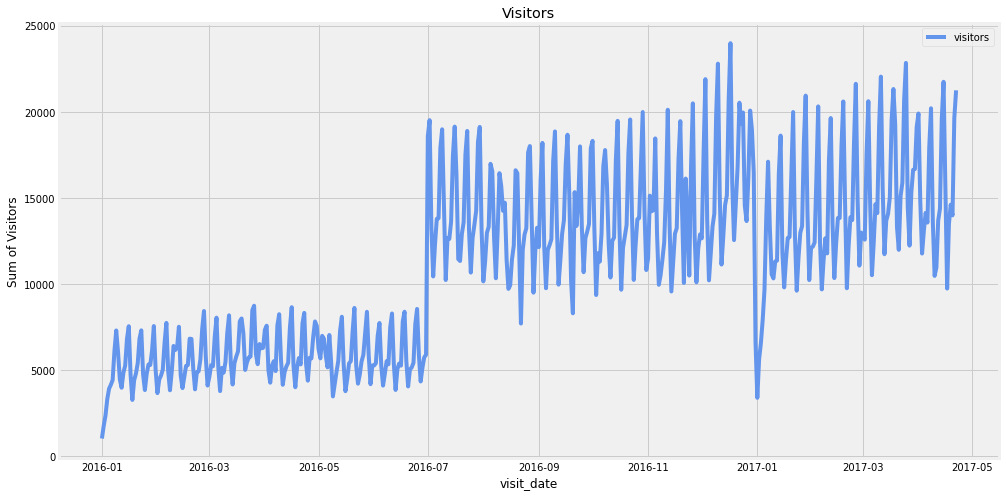

In [ ]:
#Visitor each day
f,ax = plt.subplots(1,1,figsize=(15,8))

plt1 = data['tra'].groupby(['visit_date'], as_index=False).agg({'visitors': np.sum})
plt1=plt1.set_index('visit_date')
plt1.plot(color='cornflowerblue', kind='line', ax=ax)

plt.ylabel("Sum of Visitors")
plt.title("Visitors")

In [ ]:
import folium
from folium import plugins

location =stores.groupby(['latitude', 'longitude']).size().reset_index()
locationheat = location[['latitude', 'longitude']]
locationheat = locationheat.values.tolist()

map1 = folium.Map(location=[39, 139], 
                        tiles = "Stamen Watercolor",# width=1000, height=500,
                        zoom_start = 5)
heatmap=plugins.HeatMap(locationheat).add_to(map1)
map1

In [ ]:
location =stores.groupby(['air_store_id','air_genre_name'])['latitude','longitude'].mean().reset_index()
locationlist = location[['latitude', 'longitude']]
locationlist = locationlist.values.tolist()
map2 = folium.Map(location=[39, 139], 
                        tiles = "Stamen Toner",# width=1000, height=500,
                        zoom_start = 5)
marker_cluster=plugins.MarkerCluster().add_to(map2)
for point in range(0, len(location)):
    folium.Marker(locationlist[point],
    icon=folium.Icon(color='white', icon_color='red', 
                     #icon='fa fa-info-circle',
                     icon='fa fa-circle-o-notch fa-spin',
                     angle=0, 
                     prefix='fa')).add_to(marker_cluster)
map2

# air_visit_data 시각화
data['tra']

train

## 요일별 평균 방문자 수

In [ ]:
df = data['tra'].groupby('dow_name').mean().drop(['year', 'month', 'dow'], axis=1)


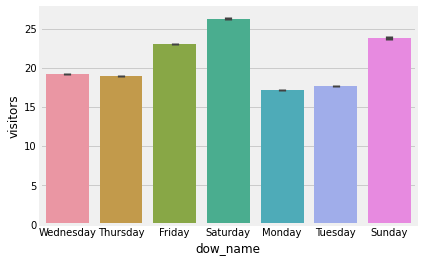

In [ ]:
fig = plt.figure()

sns.barplot(x='dow_name', y='visitors', data=data['tra'])

## 방문자 수 빈도 

[[Python] Python에서 R ggplot2 함수로 그래프 그리기 (by PlotNine library)](https://rfriend.tistory.com/420)

<Figure size 432x288 with 0 Axes>

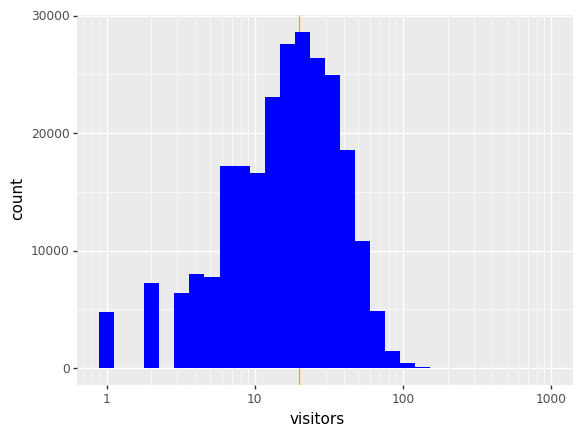

<ggplot: (8750049423993)>

In [ ]:
from plotnine import *

fig = plt.figure()

ggplot(data['tra'], aes('visitors')) +\
  geom_vline(xintercept = 20, color = 'orange') +\
  geom_histogram(fill = 'blue', bins = 30) +\
  scale_x_log10()

In [ ]:
import matplotlib.font_manager as fm

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette('husl',9)
%matplotlib inline

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette('husl',9)
%matplotlib inline
font_path = '/kaggle/input/nanumgothic/NanumGothic.ttf'
plt.rcParams['axes.unicode_minus']=False
font_name=fm.FontProperties(fname=font_path,size=10)
plt.rcParams['font.family']=font_name.get_name()

FileNotFoundError: ignored

In [ ]:
plt.rcParams['font.family']

### 원활한 시각화를 위한 날짜 컬럼 추가

## air_store_info
- air에는 총 829개의 가게 정보가 존재한다.

In [ ]:
data['as'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   air_store_id    829 non-null    object 
 1   air_genre_name  829 non-null    object 
 2   air_area_name   829 non-null    object 
 3   latitude        829 non-null    float64
 4   longitude       829 non-null    float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB


- air는 총 14개의 종류로 식당을 분류하고 있다.
- air에서 포괄하고 있는 지역은 103개이다.

In [ ]:
data['as'].nunique()

air_store_id      829
air_genre_name     14
air_area_name     103
latitude          108
longitude         108
dtype: int64

### 지역별 가게 장르 분포

- 지역의 개수가 많으므로 상위 10개 지역에서의 장르 분포와 더 넓은 단위의 지역별 장르 분포를 보자

In [ ]:
air_top_10 = data['as'].iloc[:,0:3].groupby('air_area_name').count().sort_values(by='air_store_id',ascending=False).head(10)

<Figure size 1440x720 with 0 Axes>

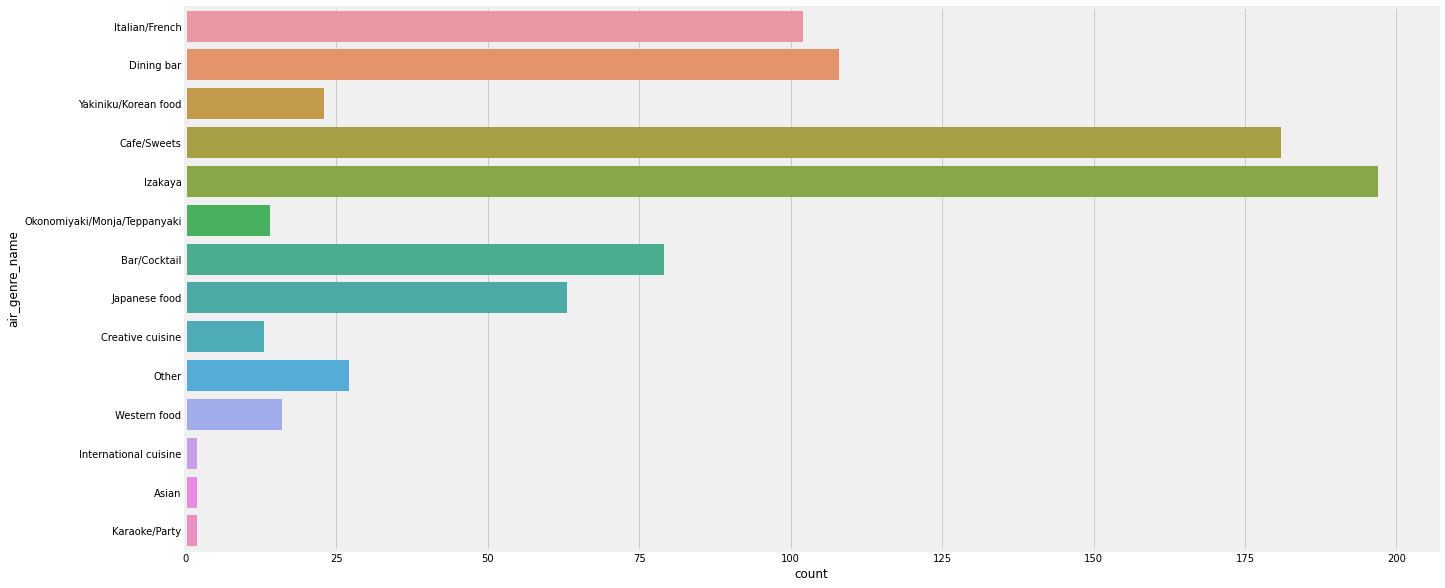

In [ ]:
plt.figure(figsize=(20,10))
sns.countplot(y=data['as']['air_genre_name'])
plt.show()

### 넓은 지역별 가게 정보 보기

- 단순 `air_area_name`으로만 보면 컬럼 수가 너무 많아서 한눈에 보기 어렵다.

<Figure size 1080x720 with 0 Axes>

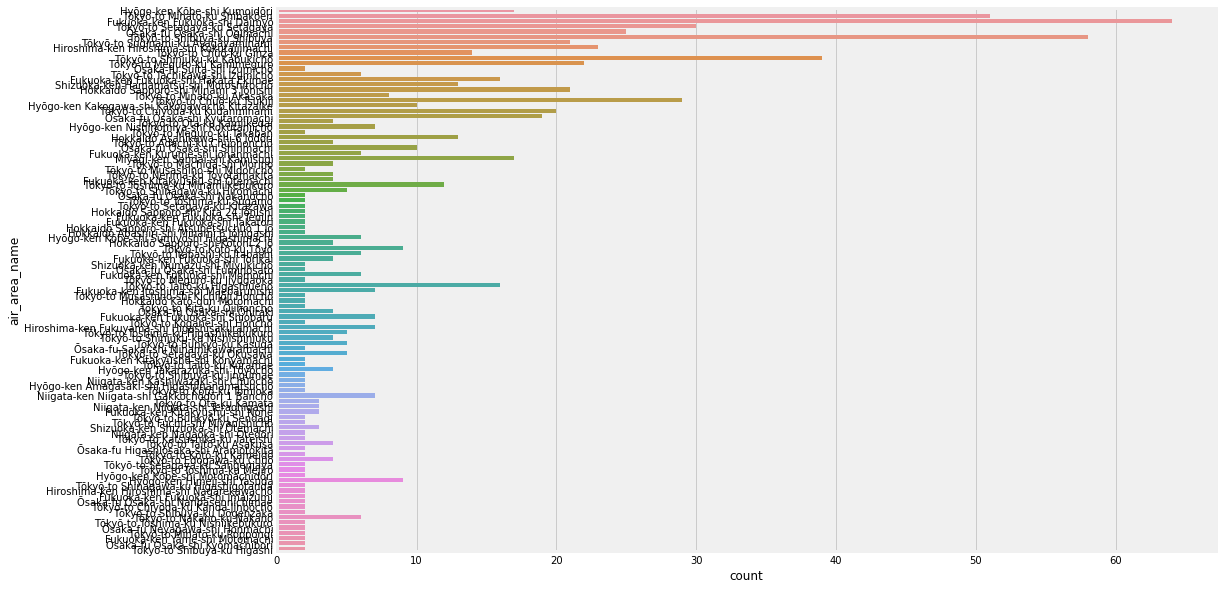

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(y=data['as']['air_area_name'])
plt.show()

- `air_area_name`는 크게 도/도/부/현, 시/구, 동으로 나뉜다.
- 우선 대단위로 그룹화해서 시각화해보자.

In [ ]:
data['as']['air_area_name'].sample(10)

159                   Tōkyō-to Meguro-ku Kamimeguro
776          Hyōgo-ken Nishinomiya-shi Rokutanjichō
298              Tōkyō-to Suginami-ku Asagayaminami
82     Hyōgo-ken Kakogawa-shi Kakogawachō Kitazaike
362         Tōkyō-to Musashino-shi Kichijōji Honchō
527                      Tōkyō-to Minato-ku Akasaka
133                     Ōsaka-fu Ōsaka-shi Ōgimachi
541    Hyōgo-ken Kakogawa-shi Kakogawachō Kitazaike
517                  Miyagi-ken Sendai-shi Kamisugi
166                    Ōsaka-fu Ōsaka-shi Shinmachi
Name: air_area_name, dtype: object

- 도도부현 정보 칼럼 추가

In [ ]:
data['as']['dodo']=data['as']['air_area_name'].apply(lambda x:x.split(' ')[0])

- 도쿄 지역의 가게가 월등히 많은 것을 알 수 있고 그 뒤를 후쿠오카와 오사카가 잇고 있다.

<Figure size 864x720 with 0 Axes>

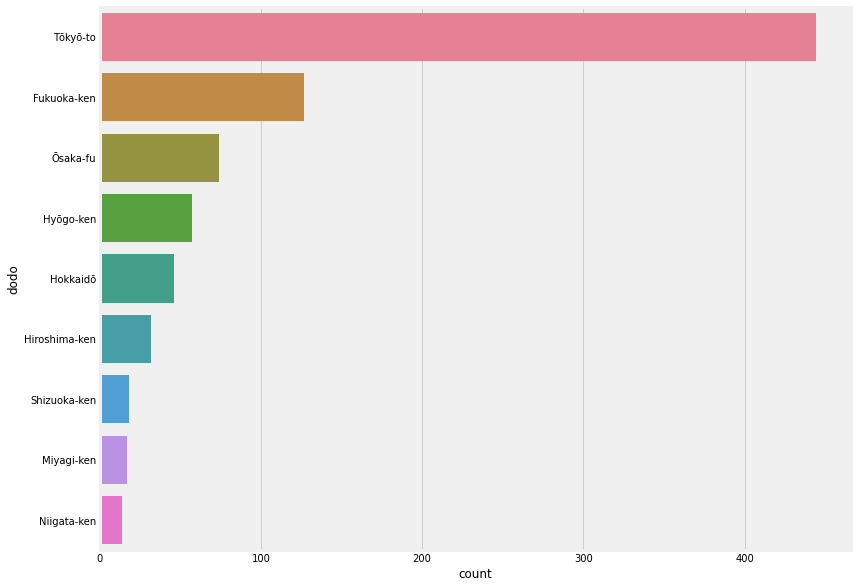

In [ ]:
plt.figure(figsize=(12,10))
sns.countplot(y=data['as']['dodo'],
             order=data['as']['dodo'].value_counts().index)
plt.show()

- 시구의 정보까지 뽑아보자.

In [ ]:
data['as']['sigu']=data['as']['air_area_name'].apply(lambda x:' '.join(x.split(' ')[:2]))
data['as'].nunique()

air_store_id      829
air_genre_name     14
air_area_name     103
latitude          108
longitude         108
dodo                9
sigu               55
dtype: int64

- 시/구 단위로 넘어오면서 컬럼 개수가 55개로 많아졌으므로 상위 25개만 보도록 하자.

<Figure size 864x720 with 0 Axes>

Text(0.5, 1.0, 'Top 25 Sigu-wise Store Count')

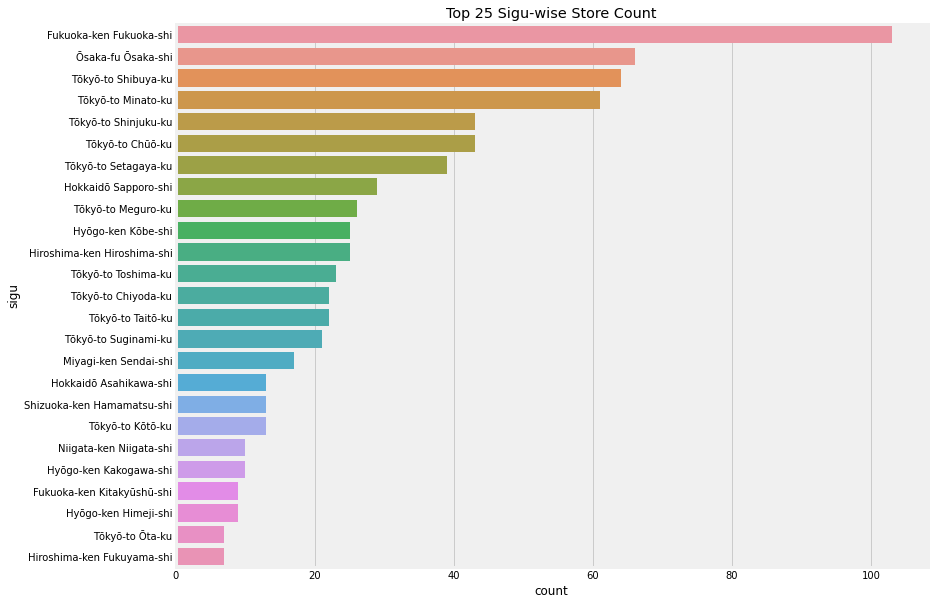

In [ ]:
plt.figure(figsize=(12,10))
sns.countplot(y=data['as']['sigu'],
             order=data['as']['sigu'].value_counts().iloc[:25].index)
plt.title('Top 25 Sigu-wise Store Count')
plt.show()

- 시/구 단위로 가장 많은 점포수를 보유한 곳은 후쿠오카시였다. 그 뒤를 오사카시와 시부야구가 뒤를 이었다.

## hpg_store_info

- hpg에는 총 4690개 점포가 입점되어 있다.

In [ ]:
data['hs'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63 entries, 0 to 62
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   hpg_store_id    63 non-null     object 
 1   hpg_genre_name  63 non-null     object 
 2   hpg_area_name   63 non-null     object 
 3   latitude        63 non-null     float64
 4   longitude       63 non-null     float64
 5   air_store_id    63 non-null     object 
dtypes: float64(2), object(4)
memory usage: 3.4+ KB


- hpg는 총 34개의 종류로 식당을 분류하고 있다.
- hpg에서 포괄하고 있는 지역은 129개이다.

In [ ]:
data['hs'].nunique()

hpg_store_id      63
hpg_genre_name    16
hpg_area_name     33
latitude          34
longitude         34
air_store_id      63
dtype: int64

In [ ]:
hpg_top_10 = data['hs'].iloc[:,0:3].groupby('hpg_area_name').count().sort_values(by='hpg_store_id',ascending=False).head(10)

- 장르 중에서 유의미한 점포 개수를 보유하고 있는 장르 수가 10개 내외이다.
- 또한 대부분의 장르가 `Japanese Style`으로 구분되어서

<Figure size 1440x720 with 0 Axes>

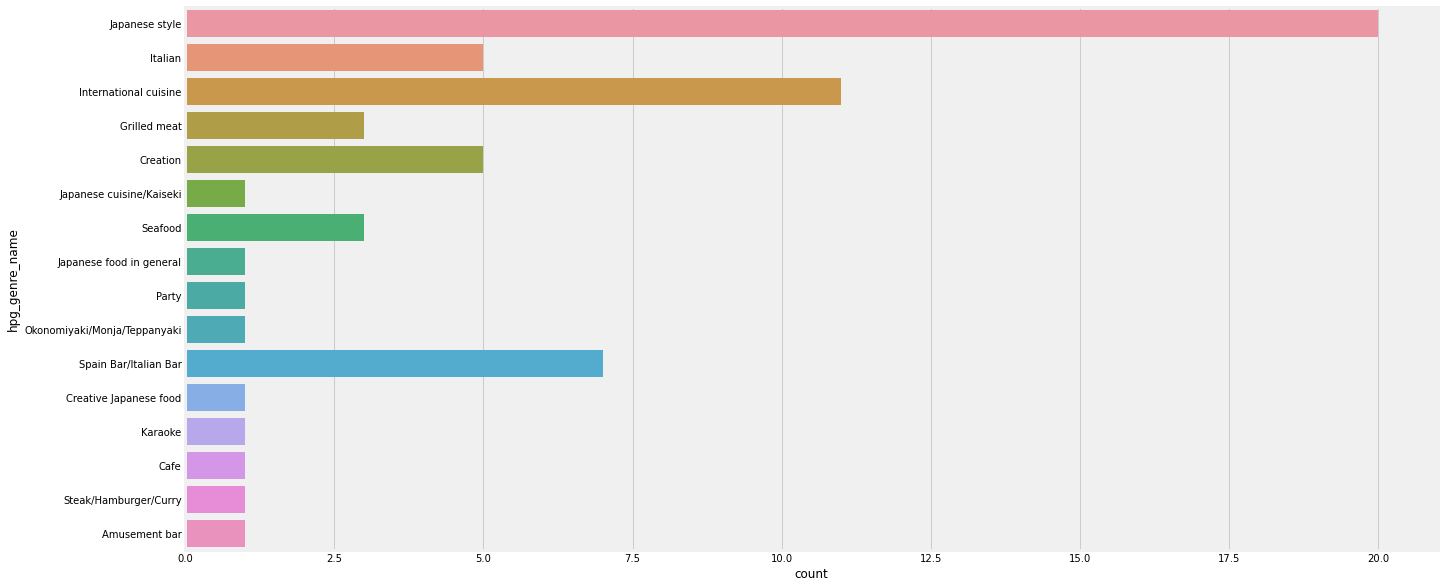

In [ ]:
plt.figure(figsize=(20,10))
sns.countplot(y=data['hs']['hpg_genre_name'])
plt.show()

In [ ]:
data['hs']['dodo']=data['hs']['hpg_area_name'].apply(lambda x:x.split(' ')[0])


- hpg에서 눈여겨볼 점은 도쿄와 다른 지역이 월등히 차이가 있으며
- 후쿠오카와 오사카의 순위가 바뀐 것 이외에 큰 변화는 없다.
- air에서 보지 못했던 None이 발생했다.

<Figure size 864x720 with 0 Axes>

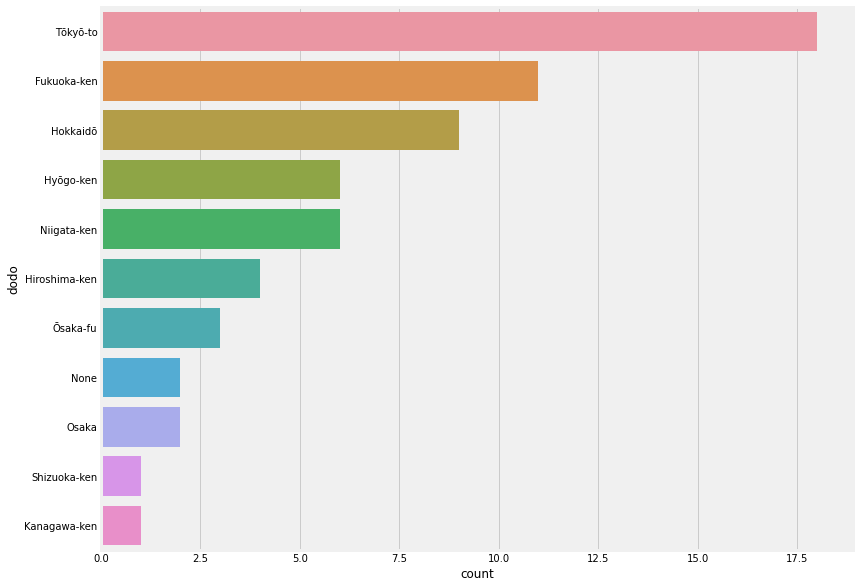

In [ ]:
plt.figure(figsize=(12,10))
sns.countplot(y=data['hs']['dodo'],
             order=data['hs']['dodo'].value_counts().index)
plt.show()

- 실제 지역 이름과 위도, 경도가 입력되지 않은 채 `store_id`만 있는 정보가 약 117개가 있었다.

In [ ]:
data['hs']['dodo'].unique()

array(['Tōkyō-to', 'Hiroshima-ken', 'Ōsaka-fu', 'Kanagawa-ken',
       'Niigata-ken', 'Fukuoka-ken', 'Hyōgo-ken', 'None', 'Shizuoka-ken',
       'Osaka', 'Hokkaidō'], dtype=object)

In [ ]:
len(data['hs'][data['hs']['dodo']=='None'])

2

- 시구 정보를 추출한 칼럼을 추가하자

In [ ]:
data['hs']['sigu']=data['hs']['hpg_area_name'].apply(lambda x:' '.join(x.split(' ')[:2]))
data['hs'].nunique()

hpg_store_id      63
hpg_genre_name    16
hpg_area_name     33
latitude          34
longitude         34
air_store_id      63
dodo              11
sigu              25
dtype: int64

- hpg 가맹 점포는 상대적으로 오사카와 도쿄에 더 

<Figure size 864x720 with 0 Axes>

Text(0.5, 1.0, 'Top 25 Sigu-wise Store Count')

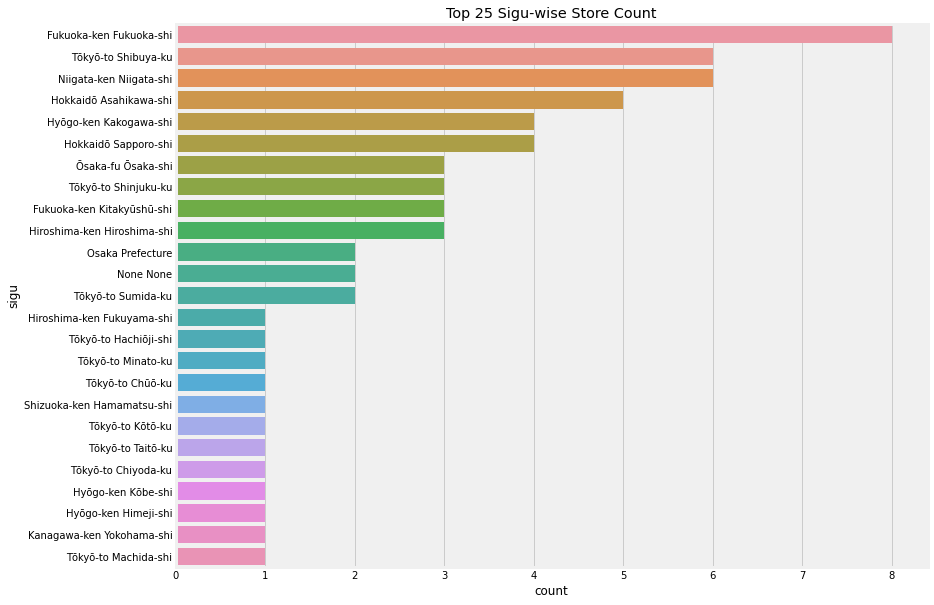

In [ ]:
plt.figure(figsize=(12,10))
sns.countplot(y=data['hs']['sigu'],
             order=data['hs']['sigu'].value_counts().iloc[:25].index)
plt.title('Top 25 Sigu-wise Store Count')
plt.show()

- air에 비해 후쿠오카시 소재 가게의 비율이 낮은 편이다. 지역 정보가 없는 정보도 다수 존재한다.

## 지역별 방문자수, 예약자수

In [ ]:
visit = pd.merge(data['tra'],data['as'])
visit.nunique()
visit.isnull().sum()

air_store_id      829
visit_date        478
visitors          204
dow                 7
year                2
month              12
dow_name            7
year_mth           16
air_genre_name     14
air_area_name     103
latitude          108
longitude         108
dodo                9
sigu               55
dtype: int64

air_store_id      0
visit_date        0
visitors          0
dow               0
year              0
month             0
dow_name          0
year_mth          0
air_genre_name    0
air_area_name     0
latitude          0
longitude         0
dodo              0
sigu              0
dtype: int64

## 가게 유형별 방문자수
- 한 가게의 일일 방문자수가 877명에 육박하는 등 이상치가 존재해서 방문자 수의 끝에 제한을 걸어보자

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

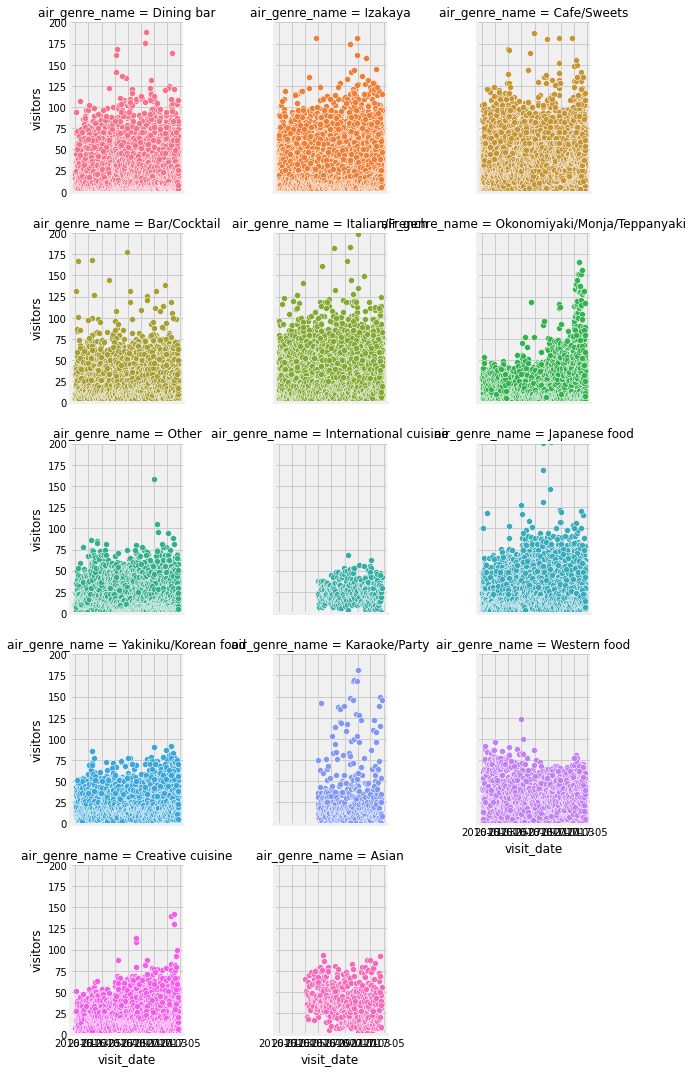

In [ ]:
plt.figure(figsize=(12,10))
sns.FacetGrid(visit, col='air_genre_name',hue='air_genre_name',col_wrap=3,
             ylim=(0,200)).map(sns.scatterplot,'visit_date','visitors')
plt.show()

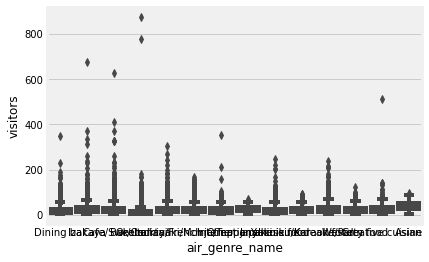

In [ ]:
plt.figsize=(20,20)
plt.ylim=(0,150)
sns.boxplot(data=visit, x='air_genre_name', y='visitors')
plt.show()

## air, hpg 두 데이터를 합칠 수는 없을까?

### air_genre_name과 hpg_genre_name을 합쳐보려는 시도..
|air_store_genre|hpg_store_genre|
|---|----|
|'Italian/French'|'Italian','French'|
|'Dining bar', ||
|'Yakiniku/Korean food'| 'Korean cuisine'| 
|'Cafe/Sweets'|'Cafe''Sweets'|
|'Izakaya'||
|'Okonomiyaki/Monja/Teppanyaki'|'Okonomiyaki/Monja/Teppanyaki'|
|'Bar/Cocktail'|'Bar/Cocktail'|
|'Japanese food', |'Japanese style', 'Udon/Soba', 'Japanese cuisine/Kaiseki','Japanese food in general','Sushi'|
|'Creative cuisine'|'Creative Japanese food'|
|'Other'||
|'Western food'|'Western food','Pasta/Pizza'|
|'International cuisine'|'Spain/Mediterranean cuisine', 'International cuisine',
|'Asian'|'Chinese general','Taiwanese/Hong Kong cuisine','Thai/Vietnamese food','Sichuan food', 'Cantonese food','Shanghai food','Dim Sum/Dumplings'|
|'Karaoke/Party'|'Karaoke','Party'|

       'Grilled meat', 'Creation', 'Shabu-shabu/Sukiyaki',
      'Seafood', 'Spain Bar/Italian Bar', , 'Bistro', 
       'Steak/Hamburger/Curry', 'Amusement bar', 

- 경도 소수점 둘째자리까지는 비슷함

# 6. store_id_relation

### 150개의 겹치는 가게 id

## id 기준으로 store 정보 합치기

### air_store_info에 air_store_id와 일치하는 hpg_store_id 컬럼 대입

In [ ]:
data['as'] = pd.merge(data['as'], data['id'], how='inner', on=['air_store_id'])

### 'hpg_store_id' 기준으로 air_store_info 와 hpg_store_info 합치기

In [ ]:
store_merge = pd.merge(data['as'], data['hs'], how='left', on=['hpg_store_id']) 

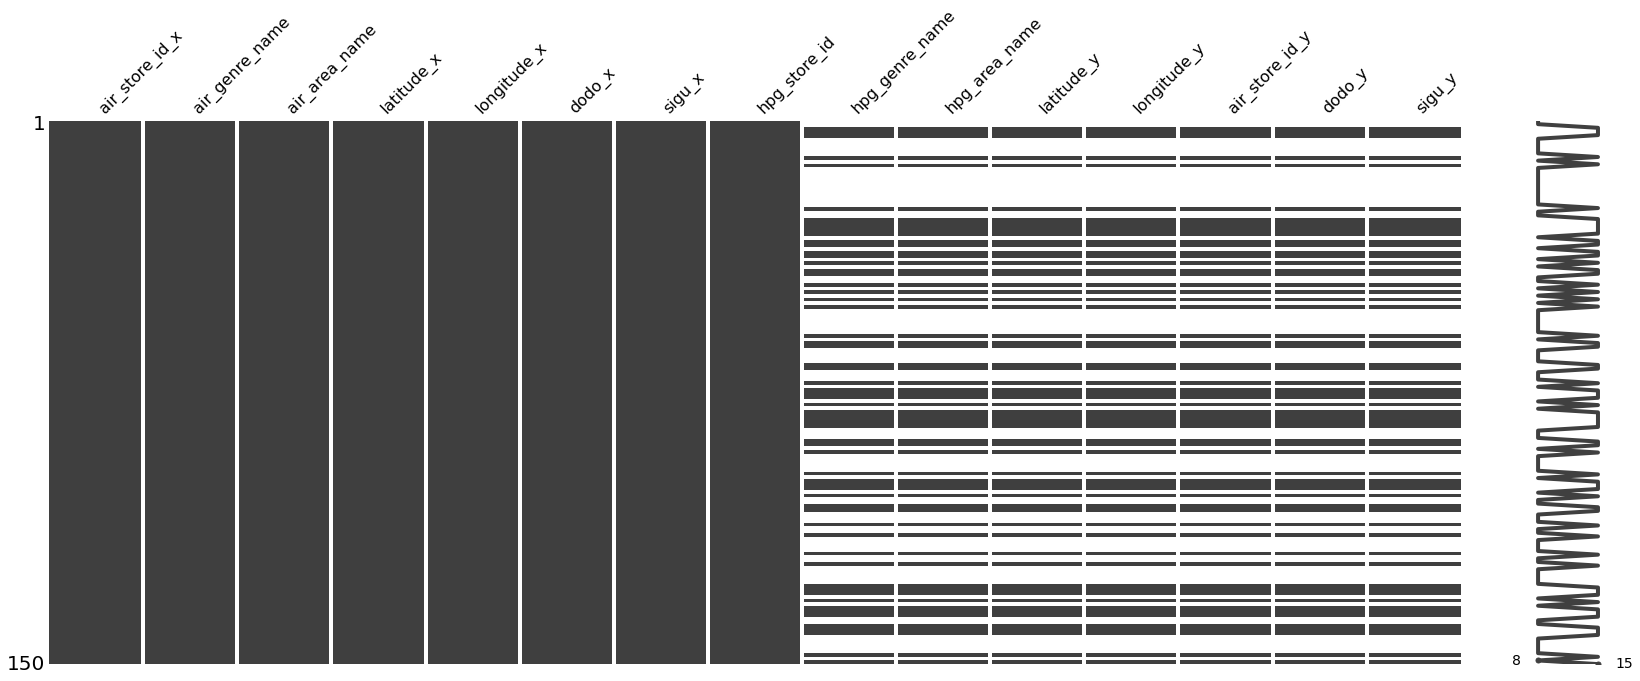

In [ ]:
import missingno as msno

msno.matrix(store_merge)

In [ ]:
store_merge.isnull().sum()

air_store_id_x     0
air_genre_name     0
air_area_name      0
latitude_x         0
longitude_x        0
dodo_x             0
sigu_x             0
hpg_store_id       0
hpg_genre_name    87
hpg_area_name     87
latitude_y        87
longitude_y       87
air_store_id_y    87
dodo_y            87
sigu_y            87
dtype: int64

### => hpg store 정보에 null값이 많이 보임

### 그 중 Null값인 row만 확인

In [ ]:
store_null =store_merge.loc[store_merge["hpg_genre_name"].isnull()]
store_null

,air_store_id_x,air_genre_name,air_area_name,latitude_x,longitude_x,dodo_x,sigu_x,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_y,longitude_y,air_store_id_y,dodo_y,sigu_y
0,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Hyōgo-ken,Hyōgo-ken Kōbe-shi,hpg_9b38b9e13da6da27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,air_290e7a57b390f78e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tōkyō-to,Tōkyō-to Minato-ku,hpg_c5ec63f52e4a7e9e,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,air_938ef91ecdde6878,Italian/French,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Tōkyō-to,Tōkyō-to Shibuya-ku,hpg_623477d346cf1822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,air_8e492076a1179383,Italian/French,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386245,132.455018,Hiroshima-ken,Hiroshima-ken Hiroshima-shi,hpg_aee92538e1b51d5f,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,air_0867f7bebad6a649,Italian/French,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386245,132.455018,Hiroshima-ken,Hiroshima-ken Hiroshima-shi,hpg_caf1082b9f445c7b,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,air_4c727b55acdee495,Creative cuisine,Hyōgo-ken Himeji-shi Yasuda,34.815149,134.685353,Hyōgo-ken,Hyōgo-ken Himeji-shi,hpg_26d20b9f926ff5e9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144,air_fea5dc9594450608,Other,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.710895,137.725940,Shizuoka-ken,Shizuoka-ken Hamamatsu-shi,hpg_6507818140022452,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,air_2cee51fa6fdf6c0d,Western food,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Tōkyō-to,Tōkyō-to Shibuya-ku,hpg_113fd6e4fa77800f,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,air_b45b8e456f53942a,Western food,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956,Hokkaidō,Hokkaidō Sapporo-shi,hpg_a85b37424291216b,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data['hs'].loc[data['hs']['hpg_store_id']=='hpg_9b38b9e13da6da27']

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude,air_store_id,dodo,sigu


In [ ]:
data['as'].loc[data['as']['air_store_id']=='air_7cc17a324ae5c7dc']

,air_store_id,air_genre_name,air_area_name,latitude,longitude,dodo,sigu,hpg_store_id
0,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Hyōgo-ken,Hyōgo-ken Kōbe-shi,hpg_9b38b9e13da6da27


### => hpg store 정보가 없는  hpg store id 들이 존재했기 때문..
### => 같은 가게인데도 air_store_info에는 존재하고 hpg_store_info 에는 존재하지 않는 경우가 있다.

# 7. date_info

In [ ]:
# 휴일만
holiday=data['hol'].loc[data['hol']['holiday_flg'] ==1]

In [ ]:
holiday['day_of_week'].value_counts()  # 공휴일인 날의 요일 분포 확인 (공휴일은 월,화인 날이 많았다.)

1    9
4    7
2    5
0    5
3    4
6    3
5    2
Name: day_of_week, dtype: int64

In [ ]:
# 날짜 데이터 타입으로 변경
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])

In [ ]:
# 4월말에서 5월의 데이터를 2016년/2017년 따로 추출
holidays16 = data['hol'][((data['hol']['visit_date'] >'2016-04-15') & (data['hol']['visit_date'] < '2016-06-01'))]
holidays17 = data['hol'][((data['hol']['visit_date'] >'2017-04-15') & (data['hol']['visit_date'] < '2017-06-01'))]

## 공휴일과 아닌 날의 count 비교

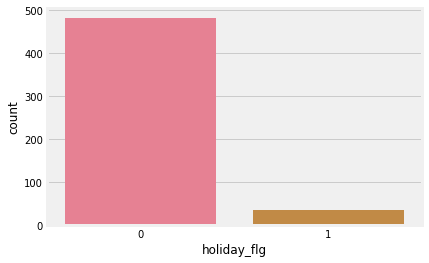

In [ ]:
sns.countplot(x="holiday_flg",data = data['hol']) 

[]

[[]]

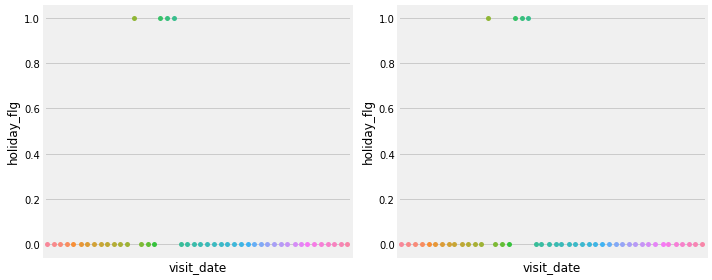

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(10,4))
plt2 = sns.stripplot(x='visit_date',y='holiday_flg',data=holidays16, ax=ax1)
plt2.set_xticks([])

plt3 = sns.stripplot(x='visit_date',y='holiday_flg',data=holidays17, ax=ax2)
plt3.set(xticks=[])

plt.tight_layout()

- 2016년 4월 말과 5월은 2017년과 휴일이 같다. (4/29, 5/3,5/4,5/5)
- data에서 휴일의 비율은 대략 7%이다.

## 공휴일여부에 따른 방문객평균

In [ ]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])

In [ ]:
tra_hol_merge = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date'])


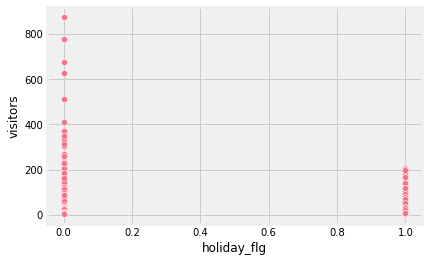

In [ ]:
sns.scatterplot(x='holiday_flg',y='visitors',data=tra_hol_merge)

* 방문객이 400명을 넘는 경우는 공휴일이 아닌 날에 많이 존재함.

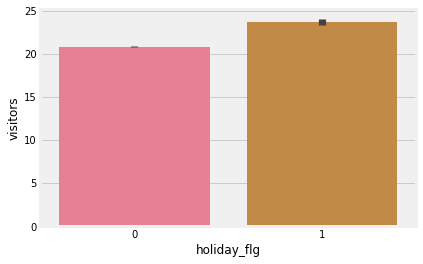

In [ ]:
sns.barplot(x='holiday_flg',y='visitors',data=tra_hol_merge)

* 하지만 평균 방문자수는 공휴일일때 더 많다.

### 공휴일 요일에 따른 방문자평균

In [ ]:
data = {
    'tra': pd.read_csv('/content/drive/MyDrive/data/air_visit_data.csv'),
    'as': pd.read_csv('/content/drive/MyDrive/data/air_store_info.csv'),
    'hs': pd.read_csv('/content/drive/MyDrive/data/hpg_store_info.csv'),
    'ar': pd.read_csv('/content/drive/MyDrive/data/air_reserve.csv'),
    'hr': pd.read_csv('/content/drive/MyDrive/data/hpg_reserve.csv'),
    'id': pd.read_csv('/content/drive/MyDrive/data/store_id_relation.csv'),
    'tes': pd.read_csv('/content/drive/MyDrive/data/sample_submission.csv'),
    'hol': pd.read_csv('/content/drive/MyDrive/data/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

In [ ]:
tra_holiday_merge = pd.merge(data['tra'],data['hol'], how='left', on=['visit_date'])


In [ ]:
onlyhol=tra_holiday_merge.loc[tra_holiday_merge['holiday_flg']==1]

In [ ]:
pvt3=onlyhol.groupby(['day_of_week'])['visitors'].mean().reset_index()

* 화요일,금요일이 공휴일일때, 평균방문자수가 제일 많았다.

### 공휴일과 아닌 날의 요일 별 평균방문자수

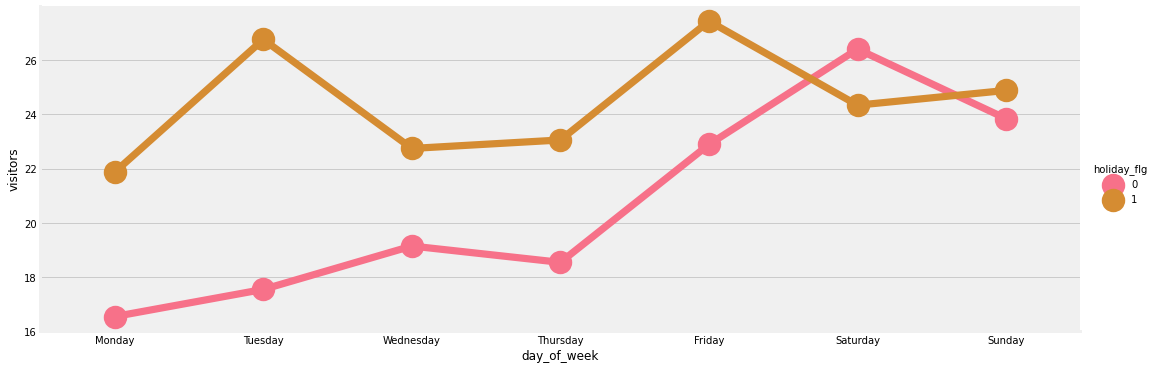

In [ ]:
df_visitors_by_dow = tra_holiday_merge.groupby(['day_of_week','holiday_flg']) \
                             .agg({'visitors':'mean'}) \
                             .reset_index() 
dow = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
df_visitors_by_dow['day_of_week'] = pd.Categorical(df_visitors_by_dow['day_of_week'],categories=dow, ordered=True)
df_visitors_by_dow.sort_values(by='day_of_week', inplace=True)
sns.factorplot(x='day_of_week', y='visitors', data=df_visitors_by_dow, hue='holiday_flg', aspect=3)

*  평균방문자 수가 공휴일이 아닌날은 토요일과 일요일에 제일 많다
* 공휴일일때 금요일이 많은 이유는 금토일 연달아 쉬니깐..? 
* 공휴일일때 토요일이 아닌날의 토요일보다 평균방문자수가 적은 이유는 공휴일이니깐 쉬고 싶어서..?

## 공휴일여부에 따른 air예약자 평균

In [ ]:
ar = pd.read_csv('/content/drive/MyDrive/data/air_reserve.csv')
hol = pd.read_csv('/content/drive/MyDrive/data/date_info.csv'),

ar['visit_datetime'] = pd.to_datetime(ar['visit_datetime'])
ar['visit_datetime'] = ar['visit_datetime'].dt.date
ar

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01,2016-01-01 01:00:00,5
...,...,...,...,...
92373,air_db4b38ebe7a7ceff,2017-05-29,2017-04-17 19:00:00,6
92374,air_1033310359ceeac1,2017-05-30,2017-04-19 17:00:00,8
92375,air_877f79706adbfb06,2017-05-31,2017-04-12 23:00:00,3
92376,air_900d755ebd2f7bbd,2017-05-31,2017-04-19 16:00:00,10


In [ ]:
ar=ar.rename(columns={
            'visit_datetime': 'visit_date'
        })
ar['visit_date'] = pd.to_datetime(ar['visit_date'])

In [ ]:
ar['visit_date'] = pd.to_datetime(ar['visit_date'])
ar_hol_merge = pd.merge(ar, data['hol'], how='left', on=['visit_date'])
ar['visit_date'] = ar['visit_date'].dt.date

In [ ]:
data['ar']
data['hol']
ar_hol_merge
data['tra']

,air_store_id,visit_date,reserve_datetime_diff,reserve_visitors
0,air_00a91d42b08b08d9,2016-10-31,0,2
1,air_00a91d42b08b08d9,2016-12-05,4,9
2,air_00a91d42b08b08d9,2016-12-14,6,18
3,air_00a91d42b08b08d9,2016-12-17,6,2
4,air_00a91d42b08b08d9,2016-12-20,2,4
...,...,...,...,...
29825,air_fea5dc9594450608,2017-04-22,0,2
29826,air_fea5dc9594450608,2017-04-25,9,2
29827,air_fea5dc9594450608,2017-04-28,29,3
29828,air_fea5dc9594450608,2017-05-20,34,6


,visit_date,day_of_week,holiday_flg
0,2016-01-01,0,1
1,2016-01-02,2,1
2,2016-01-03,3,1
3,2016-01-04,1,0
4,2016-01-05,5,0
...,...,...,...
512,2017-05-27,2,0
513,2017-05-28,3,0
514,2017-05-29,1,0
515,2017-05-30,5,0


,air_store_id,visit_date,reserve_datetime,reserve_visitors,day_of_week,holiday_flg
0,air_877f79706adbfb06,2016-01-01,2016-01-01 16:00:00,1,0,1
1,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01 19:00:00,3,0,1
2,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01 19:00:00,6,0,1
3,air_877f79706adbfb06,2016-01-01,2016-01-01 16:00:00,2,0,1
4,air_db80363d35f10926,2016-01-01,2016-01-01 01:00:00,5,0,1
...,...,...,...,...,...,...
92373,air_db4b38ebe7a7ceff,2017-05-29,2017-04-17 19:00:00,6,1,0
92374,air_1033310359ceeac1,2017-05-30,2017-04-19 17:00:00,8,5,0
92375,air_877f79706adbfb06,2017-05-31,2017-04-12 23:00:00,3,6,0
92376,air_900d755ebd2f7bbd,2017-05-31,2017-04-19 16:00:00,10,6,0


,air_store_id,visit_date,visitors,dow,year,month,dow_name,year_mth
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,Wednesday,2016-1
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,Thursday,2016-1
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,Friday,2016-1
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,Saturday,2016-1
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,Monday,2016-1
...,...,...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,1,2017,4,Tuesday,2017-4
252104,air_24e8414b9b07decb,2017-04-19,6,2,2017,4,Wednesday,2017-4
252105,air_24e8414b9b07decb,2017-04-20,7,3,2017,4,Thursday,2017-4
252106,air_24e8414b9b07decb,2017-04-21,8,4,2017,4,Friday,2017-4


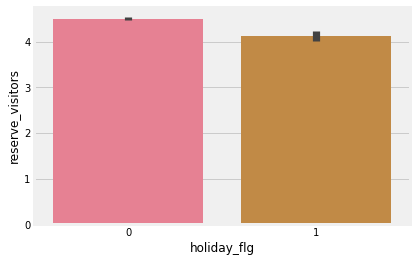

In [ ]:
sns.barplot(x='holiday_flg',y='reserve_visitors',data=ar_hol_merge)

* air 평균 예약자 수는 공휴일이 아닌 날에 더 많다.

## 공휴일여부에 따른 hpg예약자 평균

In [ ]:
hr = pd.read_csv('/content/drive/MyDrive/data/hpg_reserve.csv')

hr['visit_datetime'] = pd.to_datetime(hr['visit_datetime'])
hr['visit_datetime'] = hr['visit_datetime'].dt.date

In [ ]:
hr=hr.rename(columns={
            'visit_datetime': 'visit_date'
        })
hr['visit_date'] = pd.to_datetime(hr['visit_date'])

In [ ]:
hr_hol_merge = pd.merge(hr, data['hol'], how='left', on=['visit_date'])


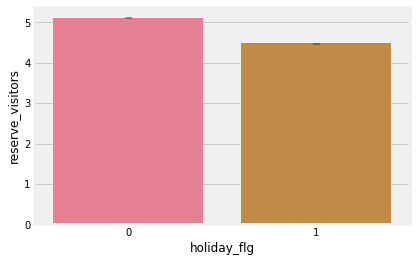

In [ ]:
sns.barplot(x='holiday_flg',y='reserve_visitors',data=hr_hol_merge)

* hpg 평균 예약자 수는 공휴일이 아닌 날에 더 많다.